In [5]:
from drn_interactions.interactions.loaders import SpontaneousActivityLoader, StateInteractionsLoader
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.config import Config, ExperimentInfo
import numpy as np
from drn_interactions.interactions.graph import GraphAttributes, NodeAttributes
import pandas as pd
import seaborn as sns
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
import matplotlib.pyplot as plt
from drn_interactions.plots import PAL_GREY_BLACK
from scipy.stats import chi2_contingency

fig_dir = Config.fig_dir
sns.set_theme(style="ticks", context="paper")

### Get Graph Results

- Graph DF (SWP, Avg Clutering etc)
- Node (Centrality, NT, Clustering etc)
- Edge DF (Weight, Distance, NT Combo, Same NT)

In [6]:
def load_responders():
    slow_responders_shock = load_derived_generic(
        "slow_ts_foot_shock_unit_responders_pre_to_shock.csv"
    )[["neuron_id", "diff_inv", "sig"]].assign(
        response_fs_slow=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["diff_inv"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_slow"]]

    fast_responders = load_derived_generic("fast_fs_foot_shock_unit_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_fs_fast=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_fs_fast"]]

    bs_response = load_derived_generic("brain_states_spikerate_responders.csv")[
        ["neuron_id", "Diff", "sig"]
    ].assign(
        response_bs=lambda x: np.where(
            x["sig"] == False,
            "no_response",
            np.where(x["Diff"] < 0, "inhibited", "activated"),
        )
    )[["neuron_id", "response_bs"]]

    df_responders = slow_responders_shock.merge(fast_responders, how="outer").merge(bs_response, how="outer")
    return df_responders
    

In [7]:

df_ensembles = load_derived_generic("ensembles/spont - ensembles - true.csv")
df_ensembles["in_ensemble"] = np.where(df_ensembles["ensemble_id"] == -1, False, True)

graph_attrs = GraphAttributes(distance_from_edge="bounded")
node_attrs = NodeAttributes()
df_responders = load_responders()
neuron_types = load_derived_generic("neuron_types.csv")[
    ["neuron_id", "neuron_type", "session_name"]
]
df_distance = load_distances()
sessions = neuron_types["session_name"].dropna().unique()

g_transform = GraphTransformer(
    relabel_nodes=True,
    weight_attr="weight",
    neuron_types=neuron_types,
    df_distance=df_distance,
    df_ensemble=df_ensembles,
)
graph_dfs = []
node_dfs = []
node_mappers = []
edge_dfs = []

for shuffle_higher in (False, True):
    for session in sessions:
        loader = SpontaneousActivityLoader(
            session_name=session, bin_width=1, block="pre", t_start=0, t_stop=1800
        )
        preprocessor = InteractionsPreprocessor()
        pairwise = PairwiseCorr(rectify=True, shuffle=shuffle_higher)

        spikes = preprocessor(loader())
        df_affinity = (
            pairwise.fit(spikes)
            .get_adjacency_df()
            .dropna(axis=1, thresh=5)
            .dropna(axis=0, thresh=5)
        )
        G = df_to_graph(df_affinity, rename_nodes=True)
        graph_stats = graph_attrs.get_graph_attributes(G).assign(session=session, shuffle=shuffle_higher)
        node_stats = node_attrs.get_node_attributes(G, node_name="neuron_id").assign(
            session=session, shuffle=shuffle_higher
        )
        edge_stats =g_transform.graph_to_edge_df(G).assign(session=session, shuffle=shuffle_higher)

        graph_dfs.append(graph_stats)
        node_dfs.append(node_stats)
        edge_dfs.append(edge_stats)

df_graph = pd.concat(graph_dfs).reset_index(drop=True)
df_node = pd.concat(node_dfs).reset_index(drop=True).merge(neuron_types[["neuron_id", "neuron_type"]], how="left")
df_node = df_node.merge(df_ensembles[["neuron_id", "in_ensemble"]], how="left")
df_edge = pd.concat(edge_dfs).reset_index(drop=True)

In [8]:
dd = Config.derived_data_dir / "graph"
dd.mkdir(parents=True, exist_ok=True)

df_graph.to_csv(dd / "spont - graph.csv", index=False)
df_node.to_csv(dd / "spont - node.csv", index=False)
df_edge.to_csv(dd / "spont - edge.csv", index=False)
df_responders.to_csv(dd / "spont - responders.csv", index=False)


In [9]:
import pingouin as pg
from drn_interactions.stats import mannwhitneyu_plusplus
from scipy.stats import wilcoxon, ttest_rel

to_compare = ["avg_deg", "avg_clust", "swp", "avg_path_len"]

def compare_one(df, to_compare, session="session_name", shuffle_col="shuffle"):
    dfp = df.pivot(index=session, columns=shuffle_col, values=to_compare)
    return mannwhitneyu_plusplus(x=dfp.iloc[:, 0], y=dfp.iloc[:, 1], names=["False", "True"], compare_f=wilcoxon)


sers = []
for col in to_compare:
    res = compare_one(df_graph, to_compare=col, session="session", shuffle_col="shuffle")
    res.name = col
    sers.append(res.to_frame())

res_graph = pd.concat(sers, axis=1).T.round(2)
display(res_graph)

/opt/miniconda3/envs/drn/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,n_False,n_True,Mean_False,Mean_True,Diff,U,p
avg_deg,22.0,22.0,0.16,0.15,-0.00,107.0,0.54
avg_clust,22.0,22.0,0.23,0.15,-0.08,0.0,0.00
swp,22.0,22.0,0.36,0.39,0.03,93.0,0.94
avg_path_len,22.0,22.0,1.07,0.85,-0.22,8.0,0.00


### Compare Node Properties

In [23]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, KFold


df = df_node.query(
    "shuffle == False"
)

def get_Xy(df, y_col, x_cols=("neuron_type"), shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y


X_str, y_str = get_Xy(df.copy(), y_col="in_ensemble", shuffle=False)
y = LabelEncoder().fit_transform(y_str)
X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
clf = DecisionTreeClassifier(max_depth=10, criterion="entropy")

score_true = cross_val_score(
    clf, 
    X, 
    y, 
    cv=KFold(shuffle=True), 
    scoring="f1_macro",).mean()

scores_obs = []
for i in range(500):
    X_str, y_str = get_Xy(df.copy(), y_col="in_ensemble", shuffle=True)
    y = LabelEncoder().fit_transform(y_str)
    X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
    score = cross_val_score(
        clf, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring="f1_macro",).mean()
    scores_obs.append(score)

scores_boot = np.array(scores_obs)
np.mean(scores_boot >= score_true)

0.44

In [24]:
df = df_node.query(
    "shuffle == False"
)

def get_Xy(df, y_col, x_cols=("neuron_type"), shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y


X_str, y = get_Xy(df.copy(), y_col="clust", shuffle=False)

X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
clf = DecisionTreeRegressor(max_depth=10)

score_true = cross_val_score(
    clf, 
    X, 
    y, 
    cv=KFold(shuffle=True), 
    scoring="r2",).mean()

scores_obs = []
for i in range(500):
    X_str, y = get_Xy(df.copy(), y_col="clust", shuffle=True)
    X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
    clf = DecisionTreeRegressor(max_depth=10)
    score = cross_val_score(
        clf, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring="r2",).mean()
    scores_obs.append(score)

scores_boot = np.array(scores_obs)
np.mean(scores_boot >= score_true)

0.0

In [25]:
df = df_node.query(
    "shuffle == False"
)

def get_Xy(df, y_col, x_cols=("neuron_type"), shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y


X_str, y = get_Xy(df.copy(), y_col="degree", shuffle=False)

X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
clf = DecisionTreeRegressor(max_depth=10)

score_true = cross_val_score(
    clf, 
    X, 
    y, 
    cv=KFold(shuffle=True), 
    scoring="r2",).mean()

scores_obs = []
for i in range(500):
    X_str, y = get_Xy(df.copy(), y_col="degree", shuffle=True)
    X = OneHotEncoder(sparse=False).fit_transform(X_str.values.reshape(-1, 1))
    clf = DecisionTreeRegressor(max_depth=10)
    score = cross_val_score(
        clf, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring="r2",).mean()
    scores_obs.append(score)

scores_boot = np.array(scores_obs)
np.mean(scores_boot >= score_true)

0.002

In [26]:
X = pd.crosstab(df["neuron_type"], df["in_ensemble"])
chi2_contingency(X)

(3.988138427744215,
 0.13614031272622235,
 2,
 array([[ 16.39145907,  77.60854093],
        [ 39.58362989, 187.41637011],
        [ 42.02491103, 198.97508897]]))

In [27]:
anova = pg.anova(data=df, dv="degree", between="neuron_type")
display(anova)
pg.pairwise_tukey(data=df, dv="degree", between="neuron_type", ).round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,neuron_type,2,559,11.793685,0.00001,0.040487


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,FF,SIR,0.19,0.13,0.06,0.01,4.40,0.0,0.54
1,FF,SR,0.19,0.17,0.02,0.01,1.71,0.2,0.21
2,SIR,SR,0.13,0.17,-0.04,0.01,-3.60,0.0,-0.33


In [28]:
anova = pg.anova(data=df, dv="clust", between="neuron_type")
display(anova)
pg.pairwise_tukey(data=df, dv="clust", between="neuron_type", ).round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,neuron_type,2,559,13.306476,0.000002,0.045445


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,FF,SIR,0.24,0.18,0.06,0.01,4.52,0.0,0.55
1,FF,SR,0.24,0.23,0.02,0.01,1.48,0.3,0.18
2,SIR,SR,0.18,0.23,-0.04,0.01,-4.04,0.0,-0.37


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


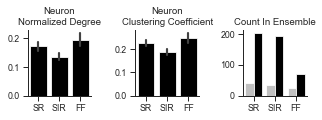

In [29]:
sns.set_palette(PAL_GREY_BLACK[::-1])
hue_order = ["SR", "SIR", "FF"]
f = plt.figure(figsize=(5, 1.2))

axes = f.subplots(1, 3, sharex=False, sharey=False)
sns.barplot(data=df, x="neuron_type", y="degree", ax=axes[0], order=hue_order, color="black")
axes[0].set_xlabel("")
axes[0].set_title("Neuron\nNormalized Degree")
axes[0].set_ylabel("")

sns.barplot(data=df, x="neuron_type", y="clust", ax=axes[1], order=hue_order, color="black")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].set_title("Neuron\nClustering Coefficient")

sns.countplot(data=df, x="neuron_type", hue="in_ensemble", ax=axes[2], order=hue_order)
axes[2].set_xlabel("")
axes[2].set_ylabel("")
axes[2].set_title("Count In Ensemble")

for ax in axes:
    ax.legend().remove()

f.subplots_adjust(wspace=0.7)

sns.despine(fig=f)
f.savefig(fig_dir / "interactions neuron bars.png", dpi=300, bbox_inches="tight")

### Compare Edge Properties

In [30]:
# weight ~ distance + nt_comb
from sklearn.compose import ColumnTransformer


df = df_edge.query(
    "shuffle == False"
)

def get_Xy(df, y_col, x_cols=["distance", "nt_comb"], shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y


X_str, y = get_Xy(df.copy(), y_col="weight", shuffle=False)


ct = ColumnTransformer(
    [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
    remainder="passthrough",
)
X = ct.fit_transform(X_str)


clf = DecisionTreeRegressor(max_depth=10)

score_true_weight = cross_val_score(
    clf, 
    X, 
    y, 
    cv=KFold(shuffle=True), 
    scoring="r2",)

scores_obs = []
for i in range(2000):
    X_str, y = get_Xy(df.copy(), y_col="weight", shuffle=True)
    ct = ColumnTransformer(
        [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
        remainder="passthrough",
    )
    X = ct.fit_transform(X_str)
    clf = DecisionTreeRegressor(max_depth=10)
    score = cross_val_score(
        clf, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring="r2",).mean()
    scores_obs.append(score)

scores_boot_weight = np.array(scores_obs)
# np.mean(scores_boot >= score_true)

In [31]:
from sklearn.compose import ColumnTransformer


df = df_edge.query(
    "shuffle == False"
)

def get_Xy(df, y_col, x_cols=["distance", "nt_comb"], shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y


X_str, y = get_Xy(df.copy(), y_col="same_ensemble", shuffle=False)
y = LabelEncoder().fit_transform(y)

ct = ColumnTransformer(
    [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
    remainder="passthrough",
)
X = ct.fit_transform(X_str)

clf = DecisionTreeClassifier(max_depth=10)

score_true_ens = cross_val_score(
    clf, 
    X, 
    y, 
    cv=KFold(shuffle=True), 
    scoring="f1_macro",).mean()

scores_obs = []
for i in range(2000):
    X_str, y = get_Xy(df.copy(), y_col="same_ensemble", shuffle=True)
    ct = ColumnTransformer(
        [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
        remainder="passthrough",
    )
    y = LabelEncoder().fit_transform(y)
    X = ct.fit_transform(X_str)
    clf = DecisionTreeClassifier(max_depth=10)
    score = cross_val_score(
        clf, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring="f1_macro",).mean()
    scores_obs.append(score)

scores_boot_ens = np.array(scores_obs)
# np.mean(scores_boot >= score_true)

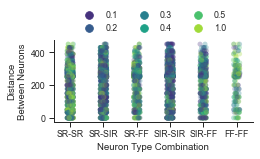

In [36]:
order = (
    "SR-SR",
    "SR-SIR",
    "SR-FF",
    "SIR-SIR",
    "SIR-FF",
    "FF-FF"
)
df = df.copy()
df["nt_comb"] = pd.Categorical(df["nt_comb"], categories=order, ordered=True)
df["Correlation"] = pd.cut(df["weight"], (0, 0.1, 0.2, 0.3, 0.4, 0.5, 1), labels=[0.1, 0.2, 0.3, 0.4, 0.5, 1])

f = plt.figure(figsize=(3.5, 2.1), constrained_layout=True)

ax = f.subplots()


sns.stripplot(data=df, x="nt_comb", y="distance", hue="Correlation",palette="viridis", alpha=0.3, jitter=1, ax=ax)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.set_ylabel("Distance\nBetween Neurons")
ax.set_xlabel("Neuron Type Combination")
sns.despine(fig=f)
f.savefig(fig_dir / "interactions neuron type distance strip.png", dpi=300, bbox_inches="tight")

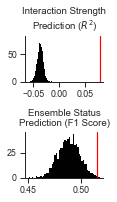

In [35]:
f = plt.figure(figsize=(1.4, 2.6))

axes = f.subplots(2, sharex=False, sharey=False)



_ = axes[0].hist(scores_boot_weight, bins=50, density=True, color="black", alpha=1, linewidth=0.01)
_ = axes[0].axvline(score_true_weight.mean(), color="red")
axes[0].set_title("Interaction Strength\nPrediction ($R^{2}$)")



_ = axes[1].hist(scores_boot_ens, bins=50, density=True, color="black", alpha=1, linewidth=0.01)
_ = axes[1].axvline(score_true_ens.mean(), color="red")
axes[1].set_title("Ensemble Status\nPrediction (F1 Score)")


f.subplots_adjust(hspace=1.1)
sns.despine(fig=f)

f.savefig(fig_dir / "Edge Prediction.png", dpi=300, bbox_inches="tight")